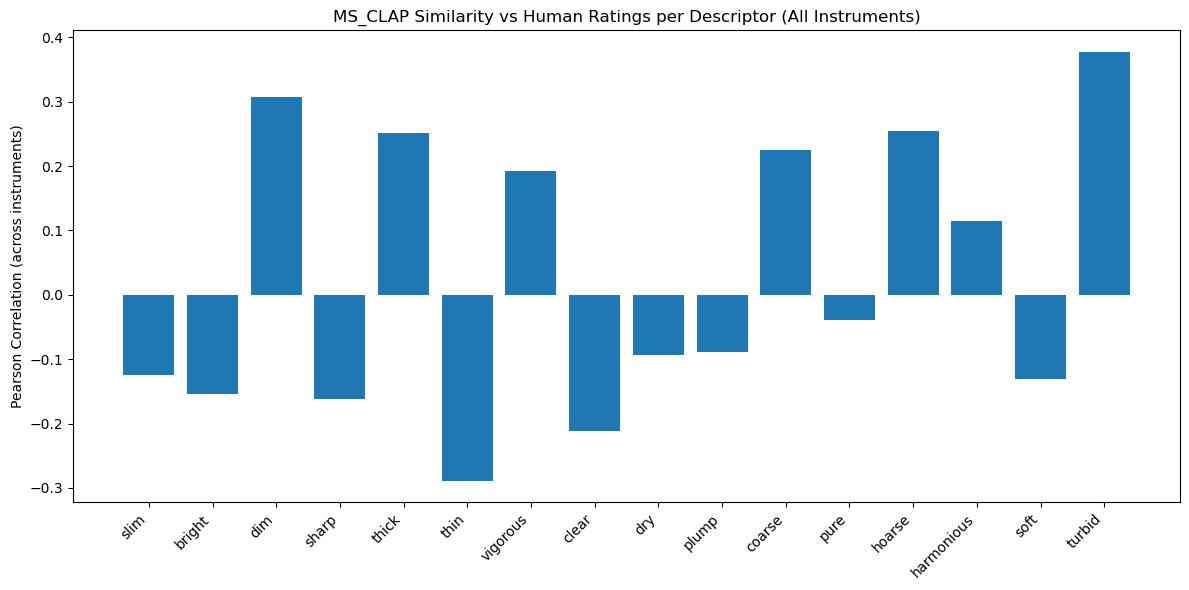

Export complete. Files saved to: /Users/lindseydeng/Desktop/Timbre_Study/timbre_semantics_exp1/results/MSCLAP


In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from msclap import CLAP
from scipy.stats import pearsonr, spearmanr

output_dir = "/results/MS_CLAP"
os.makedirs(output_dir, exist_ok=True)

# --------------------------------------------------
# 1. Load CLAP model
# --------------------------------------------------
clap_model = CLAP(version='2023', use_cuda=False)

# --------------------------------------------------
# 2.paths to data
# --------------------------------------------------
western_csv_path = " "
chinese_csv_path = " "

western_audio_folder = " "
chinese_audio_folder = ""

# --------------------------------------------------
# 3. Load data and compute audio embeddings
# --------------------------------------------------
# Western
df_western = pd.read_csv(western_csv_path)
western_paths = [os.path.join(western_audio_folder, f"{int(row['instrument_id'])}.wav") for _, row in df_western.iterrows()]
western_audio_embeddings = clap_model.get_audio_embeddings(western_paths)

# Chinese
df_chinese = pd.read_csv(chinese_csv_path)
chinese_paths = [os.path.join(chinese_audio_folder, f"{int(row['instrument_id'])}.wav") for _, row in df_chinese.iterrows()]
chinese_audio_embeddings = clap_model.get_audio_embeddings(chinese_paths)

# --------------------------------------------------
# 4. Get descriptor list and compute text embeddings
# --------------------------------------------------
descriptors = df_western.columns[2:].tolist()
text_embeddings = clap_model.get_text_embeddings(descriptors)

# --------------------------------------------------
# 5. Compute similarity matrices
# --------------------------------------------------
similarity_matrix_western = clap_model.compute_similarity(western_audio_embeddings, text_embeddings).detach().numpy()
similarity_matrix_chinese = clap_model.compute_similarity(chinese_audio_embeddings, text_embeddings).detach().numpy()

# Convert to DataFrames
similarity_df_western = pd.DataFrame(similarity_matrix_western, columns=descriptors, index=df_western['instrument_name'])
similarity_df_chinese = pd.DataFrame(similarity_matrix_chinese, columns=descriptors, index=df_chinese['instrument_name'])

# --------------------------------------------------
# 6. Combine ratings and similarity scores
# --------------------------------------------------
combined_ratings = pd.concat([df_chinese[descriptors], df_western[descriptors]], ignore_index=True)
combined_similarities = pd.concat([similarity_df_chinese[descriptors], similarity_df_western[descriptors]], ignore_index=True)

# --------------------------------------------------
# 7. Compute Pearson and Spearman correlations
# --------------------------------------------------
combined_corrs = []
for desc in descriptors:
    human_scores = combined_ratings[desc].values
    model_scores = combined_similarities[desc].values

    pearson_corr, _ = pearsonr(human_scores, model_scores)
    spearman_corr, _ = spearmanr(human_scores, model_scores)

    combined_corrs.append({
        "descriptor": desc,
        "pearson": pearson_corr,
        "spearman": spearman_corr
    })

combined_corr_df = pd.DataFrame(combined_corrs)

# --------------------------------------------------
# 8. Plot Pearson correlations
# --------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(combined_corr_df['descriptor'], combined_corr_df['pearson'])
plt.ylabel('Pearson Correlation (across instruments)')
plt.title('MS_CLAP Similarity vs Human Ratings per Descriptor (All Instruments)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "msclap_all_instruments_descriptor_correlation.png"))
plt.show()



# --------------------------------------------------
# 9. Export Results
# --------------------------------------------------

# Save correlations
combined_corr_df.to_csv(os.path.join(output_dir, "msclap_descriptor_correlations.csv"), index=False)

# Save similarity matrices
similarity_df_western.to_csv(os.path.join(output_dir, "similarity_matrix_western.csv"))
similarity_df_chinese.to_csv(os.path.join(output_dir, "similarity_matrix_chinese.csv"))

# Optional: Save combined human ratings and model similarity scores
combined_ratings.to_csv(os.path.join(output_dir, "combined_human_ratings.csv"), index=False)
combined_similarities.to_csv(os.path.join(output_dir, "combined_model_similarities.csv"), index=False)

print("Export complete. Files saved to:", output_dir)



In [3]:
#  Correlation per Instrument (Semantic Profile Match)
def compute_instrument_profile_correlations(human_df, model_df, name_col):
    correlations = []
    for idx, row in human_df.iterrows():
        human_vector = row[descriptors].values
        model_vector = model_df.iloc[idx][descriptors].values

        pearson_corr, _ = pearsonr(human_vector, model_vector)
        spearman_corr, _ = spearmanr(human_vector, model_vector)

        correlations.append({
            "instrument": row[name_col],
            "pearson": pearson_corr,
            "spearman": spearman_corr
        })
    return pd.DataFrame(correlations)

# Compute per-instrument profile correlations
chinese_profile_corr_df = compute_instrument_profile_correlations(df_chinese, similarity_df_chinese, "instrument_name")
western_profile_corr_df = compute_instrument_profile_correlations(df_western, similarity_df_western, "instrument_name")

# Optional: combine both
combined_profile_corr_df = pd.concat([chinese_profile_corr_df, western_profile_corr_df], ignore_index=True)

# --------------------------------------------------
# 14. Export per-instrument profile correlations
# --------------------------------------------------
chinese_profile_corr_df.to_csv(os.path.join(output_dir, "clap_instrument_profile_correlation_chinese.csv"), index=False)
western_profile_corr_df.to_csv(os.path.join(output_dir, "clap_instrument_profile_correlation_western.csv"), index=False)
combined_profile_corr_df.to_csv(os.path.join(output_dir, "clap_instrument_profile_correlation_combined.csv"), index=False)


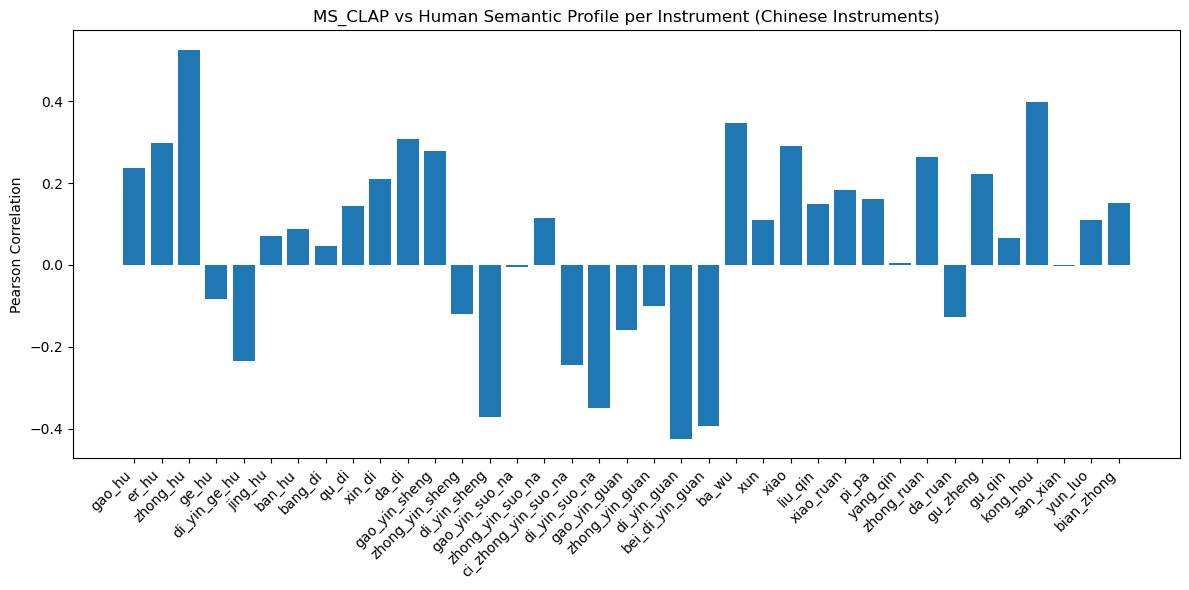

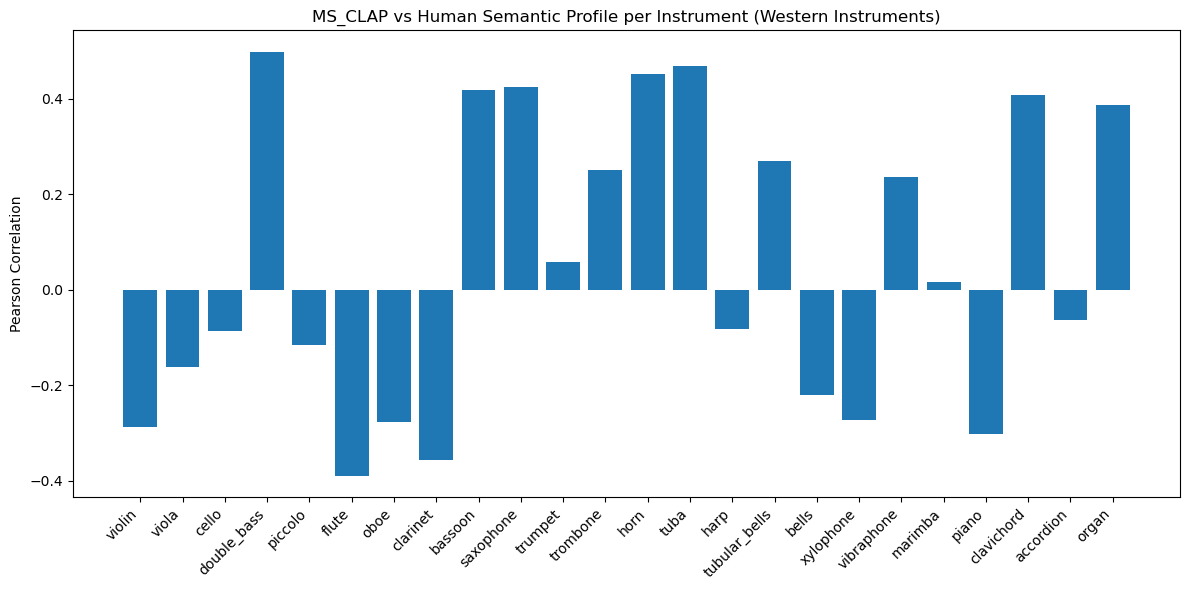

In [4]:
# Plot and Export CLAP vs Human Semantic Profile per Instrument

# Plot: Chinese instruments
plt.figure(figsize=(12, 6))
plt.bar(chinese_profile_corr_df['instrument'], chinese_profile_corr_df['pearson'])
plt.ylabel('Pearson Correlation')
plt.title('MS_CLAP vs Human Semantic Profile per Instrument (Chinese Instruments)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "clap_profile_correlation_per_instrument_chinese.png"))
plt.show()

# Plot: Western instruments
plt.figure(figsize=(12, 6))
plt.bar(western_profile_corr_df['instrument'], western_profile_corr_df['pearson'])
plt.ylabel('Pearson Correlation')
plt.title('MS_CLAP vs Human Semantic Profile per Instrument (Western Instruments)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "clap_profile_correlation_per_instrument_western.png"))
plt.show()